<a href="https://colab.research.google.com/github/beatLaboratory/TIMBRE/blob/main/LFP_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run TIMBRE on real data

In this notebook we import the experimental data and use LFP and spikes to predict which maze arm the rat is occupying.

First, let's install TIMBRE and its dependencies.

In [ ]:
#!git clone https://github.com/beatLaboratory/TIMBRE.git
#!pip install -r requirements.txt
#!pip install requests
!pip install scipy

# Download data

We will download LFP, spike, and behavioral data. We will use experimental session 4 because it is smaller and therefore faster to run.

In [ ]:
import requests
import os
from scipy import io as iomat
import io

import numpy as np
import rat.helpers as helpers

repository_id = "24757638"  # Behavior_and_spiking_data_for_rats_running_a_3-arm_maze
url = f"https://api.figshare.com/v2/articles/{repository_id}"

# Make the API request
response = requests.get(url)
files = response.json()['files']

file_pattern = "data04.mat"

# Find the matching files
file = next((file for file in files if file['name'] == file_pattern), None)

if file:
    # Download the file using requests (previously wget, but not universal across shells)
    download_url = file['download_url']
    file_name = file['name']
    print(f"Downloading file: {file_name}")
    response = requests.get(download_url)
    
    # Load the .mat file directly from the response content
    data = iomat.loadmat(io.BytesIO(response.content))

LFPs = helpers.filter_data(data['lfps'], 2, fs=25, use_hilbert=True)


# Visualize network behavior

We will train TIMBRE with different hidden layer sizes and look at the average response in each layer as a function of position along the track. We do this for the phase in which the animal is running towards the reward port while in one of the 3 maze arms. Note that for larger hidden layer sizes, the hidden nodes' responses are localized in position, even though this information is not provided to the network during training.

Initial train_inds (before balancing): 3151
actual_indices length: 3151
unique_elements: [0. 1. 2.]
elements_indices: {0.0: [3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7190, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974, 9975, 13444, 13445, 13446, 13447, 13448, 13449, 13450, 13451, 13452, 13453, 13454, 13455, 13456, 13457, 13458, 13459, 13460, 13461, 13462, 13463, 13464, 13465, 13466, 13467, 13468, 13469, 13470, 13471, 13472, 13473,

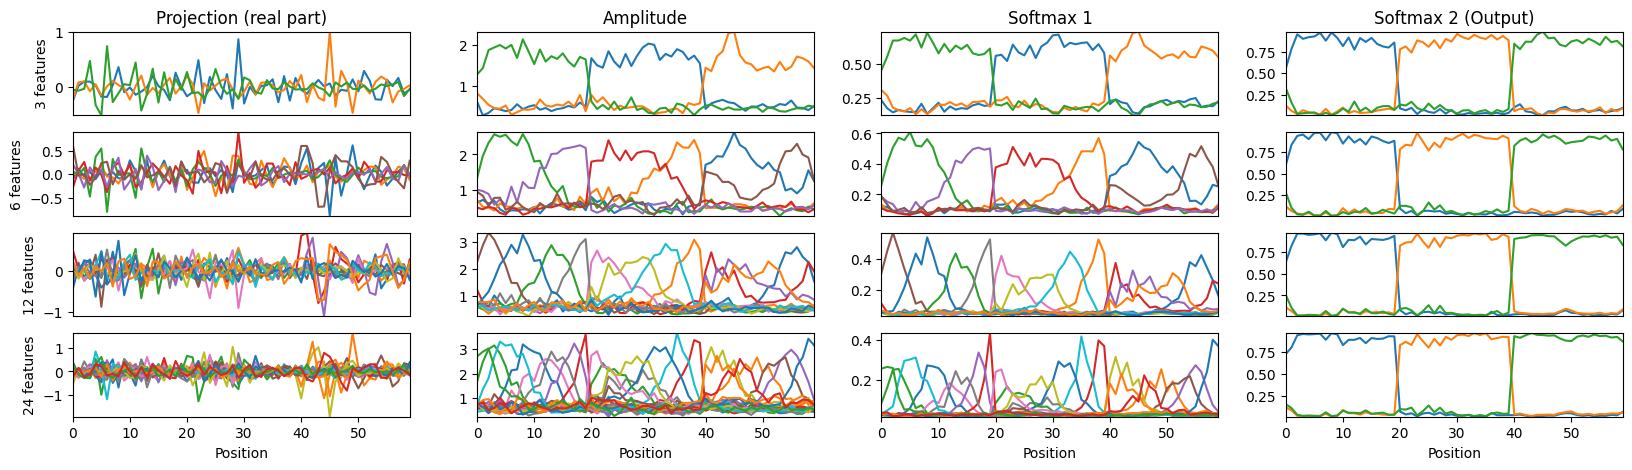

In [2]:
from matplotlib import pyplot as plt
from TIMBRE import TIMBRE

fig, axs = plt.subplots(4, 4, figsize=(20, 5))

trial_phase = 1
n_folds = 5
which_fold = 0

lapID = data['lapID']

test_inds, train_inds = helpers.test_train(data['lapID'], trial_phase, n_folds, which_fold)  # only test 1 fold per session
wLFPs, _, _ = helpers.whiten(LFPs, train_inds)

# Verify the shapes of the indices arrays
print(f"Test indices shape: {test_inds.shape}")
print(f"Train indices shape: {train_inds.shape}")

# Additional debug statements to verify input to TIMBRE
print(f"X (wLFPs) shape: {wLFPs.shape}")
print(f"Y (lapID[:, 1]) shape: {lapID[:, 1].shape}")
print(f"inds_train shape: {train_inds.shape}")
print(f"inds_test shape: {test_inds.shape}")
print(f"X[inds_train, :] shape: {wLFPs[train_inds, :].shape}")
print(f"Y[inds_train] shape: {lapID[train_inds, 1].shape}")
print(f"X[inds_test, :] shape: {wLFPs[test_inds, :].shape}")
print(f"Y[inds_test] shape: {lapID[test_inds, 1].shape}")

n_bins = 20
pos_binned = helpers.group_by_pos(data['lapID'][:, 4], n_bins, train_inds)  # Convert position along the track into discrete bins.
arm_and_pos_binned = data['lapID'][:, 1] * n_bins + pos_binned  # Represent arm x position as integer between 0-19 (arm 1), 20-39 (arm 2), 40-59 (arm 3)



titles = ['Projection (real part)', 'Amplitude', 'Softmax 1', 'Softmax 2 (Output)'];
for i in range(axs.shape[0]):
    print(f"Training network {i + 1} of {axs.shape[0]} (hidden layer size {3 * 2 ** i})")  # try 4 different hidden layer sizes
    m, _, _ = TIMBRE(wLFPs, data['lapID'][:, 1], test_inds, train_inds, hidden_nodes=3 * 2 ** i)  # train network
    for j in range(axs.shape[1]):  # Loop through each layer
        p = helpers.layer_output(wLFPs[test_inds], m, j)  # Calculate layer's response to input, using only test data
        if j == 0:
            p = p[:, :p.shape[1] // 2]  # just get real component for complex-valued output
            axs[i, 0].set_ylabel(str(3 * 2 ** i) + ' features');
        if i == 0:
            axs[0, j].set_title((titles[j]));
        axs[i, j].plot(helpers.accumarray(arm_and_pos_binned[test_inds], p));  # plot mean response of layer to test data as a function of position
        axs[i, j].autoscale(enable=True, axis='both', tight=True);
        if i < axs.shape[0] - 1:
            axs[i, j].set_xticks([]);
        else:
            axs[i, j].set_xlabel('Position');
